# Web data: Amazon reviews

Opis danych ze strony http://snap.stanford.edu/data/web-Amazon-links.html
- product/productId: asin, e.g. amazon.com/dp/B00006HAXW
- product/title: title of the product
- product/price: price of the product
- review/userId: id of the user, e.g. A1RSDE90N6RSZF
- review/profileName: name of the user
- review/helpfulness: fraction of users who found the review helpful
- review/score: rating of the product
- review/time: time of the review (unix time)
- review/summary: review summary
- review/text: text of the review 

# Import potrzebnych modułów

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gzip
import re
import string
import nltk
import tensorflow as tf
from datetime import datetime, date
from itertools import combinations
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
pd.set_option("display.precision", 4)
plt.style.use('ggplot')
%matplotlib inline

# Załadowanie danych do Pandas DataFrame

In [2]:
def parse(filename):
    f = gzip.open(filename, 'rt')
    entry = {}
    for l in f:
        l = l.strip()
        colonPos = l.find(':')
        if colonPos == -1:
            yield entry
            entry = {}
            continue
        eName = l[:colonPos]
        rest = l[colonPos+2:]
        entry[eName] = rest
    yield entry


def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


df = getDF('Cell_Phones_&_Accessories.txt.gz')
df.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and se..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoot...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up...w...
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,The price was right for this cable ($11.95+$4....
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, Z...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...


# Preprocessing danych

Zmiana typów danych

In [3]:
df["review/score"] = df["review/score"].astype("float64")

print("Rozmiar zbioru danych: " + str(df.shape))

Rozmiar zbioru danych: (78930, 10)


Wypisanie oraz usunięcie zduplikowanych rekordów

In [4]:
duplicated_rows_df = df[df.duplicated()]
print(f"Liczba zduplikowanych rekordów: {duplicated_rows_df.shape[0]}")
print("Zduplikowane rekordy: ")
duplicated_rows_df.head(3)

Liczba zduplikowanych rekordów: 36
Zduplikowane rekordy: 


,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
90,B00004WINT,Jabra EarGels - Clear,9.70,A37XJZF145XH5B,A. Trujillo,4/4,5.0,1214265600,Comfort at last,"I bought these eargels for my bluetooth, which..."
5248,B00074V0JY,Motorola Lithium-Ion Battery BR50 / SNN5696 / ...,4.51,A2JKD82K7NWK1U,"R. Badger ""Knower of All, Master of None""",3/3,5.0,1154822400,GREAT battery,Oredered this battery thinking it was the olde...
6108,B00006I9SY,Plantronics M1500 Bluetooth Headset With Adapt...,unknown,unknown,unknown,2/6,1.0,1051660800,Uncomfortable earpiece..,The product works fine but the earpiece is way...


In [5]:
df.drop_duplicates(keep="first", inplace=True)
print("Rozmiar zbioru po usunięciu duplikatów: " + str(df.shape))

Rozmiar zbioru po usunięciu duplikatów: (78894, 10)


Utworzenie dodatkowych kolumn

In [6]:
# Dodanie kolumny zawierającej długość tekstu
df['text_length'] = df['review/text'].apply(len)

# Kolumna zawierająca wartości 0 i 1. Jeżeli opinia była negatywna, miała opinię mniejszą lub równą 3, przypisywana
#                                                                            jest wartość 0, 1 w reszcie przypadków)
df['score_bool'] = df['review/score'].apply(lambda row: 0 if row <= 3.0 else 1)

# Kolumna zamieniająca format daty
df['date'] = pd.to_datetime(df['review/time'], unit='s')

# Kolumny zawierające rok, miesiąc, dzień oraz dzień tygodnia - pomocne przy późniejszych analizach
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

# Kolumny zawierające przydatność opinii
df['good_helpfulness'] = df['review/helpfulness'].apply(lambda row: row.split('/')[0]) # Ilość osób, która uważa opinię za użyteczną
df['all_helpfulness'] = df['review/helpfulness'].apply(lambda row: row.split('/')[1]) # Ilość osób, która oceniła opinię

df['good_helpfulness'] = df['good_helpfulness'].astype("int64")
df['all_helpfulness'] = df['all_helpfulness'].astype("int64")

Usunięcie niepotrzebnych kolumn oraz zamiana nazw istniejących

In [7]:
df.drop(['product/productId', 'review/profileName', 'review/helpfulness', 'review/time', 'date'], axis=1, inplace=True)

df.rename(columns={'product/title': 'title', 'product/price': 'price', 'review/userId': 'user_id',
           'review/score': 'score', 'review/summary': 'summary', 'review/text': 'text'}, inplace=True)

Przekształcenie tekstu

In [8]:
# Usunięcie spacji na początku i na końcu tytułu oraz zamiana na małe litery
df['title'] = df['title'].apply(lambda x: x.strip().lower())

# Późniejsza analiza wykazała, że ponad 500 rekordów nie posiada nazw produktu, takie rekordy nie będą przydatne
df = df[df['title'] != '']

In [9]:
def clean_text(text):

    # Usunięcie spacji na początku i końcu tekstu
    text.strip().lower()
    
    # Zamiana wszystkich liczb na słowo 'number'
    text = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', r'number', text)
    
    # Usunięcie interpunkcji
    punc = str.maketrans('', '', string.punctuation)
    text = text.translate(punc)

    # Zamiana url na słowo 'url'
    text = re.sub(r"http\S+", 'url', text)
    
    # Usunięcie stopwords - słów które nie wnoszą treści do zdania, np. "a", "to", "of"
    text = ' '.join([word.lower() for word in text.split() if not word in stopwords.words('english')])
    
    # Lematyzacja słów (sprowadzenie do podstawowej postaci): "dogs" --> "dog"
    lemmer = WordNetLemmatizer()
    text = ' '.join([lemmer.lemmatize(word) for word in text.split(' ')])
    
    return text

In [10]:
# Utworzenie nowej kolumny składającej się z oczyszczonego tekstu z kolumn summary oraz text
df['clean_text'] = df[['summary', 'text']].apply(lambda x: ' '.join(x), axis=1)
df['clean_text'] = df['clean_text'].apply(clean_text)

# df.to_csv('clean_data.csv')

In [11]:
# Oczyszczanie tekstu trwa dosyć długo, dla wygody, oczyszczone dane zostały zapisane w formacie csv, oraz odczytane
# df = pd.read_csv('clean_data.csv')
# df.drop(columns='Unnamed: 0', inplace=True)

Wygląd danych po przekształceniach

In [12]:
df.head()

,title,price,user_id,score,summary,text,text_length,score_bool,date,year,month,day,weekday,good_helpfulness,all_helpfulness,clean_text
0,mobile action ma730 handset manager - bluetoot...,unknown,A1RXYH9ROBAKEZ,1.0,Don't buy!,"First of all, the company took my money and se...",716,0,2009-01-31,2009,1,31,5,0,0,dont buy first company took money sent email t...
1,mobile action ma730 handset manager - bluetoot...,unknown,A7L6E1KSJTAJ6,5.0,Mobile Action Bluetooth Mobile Phone Tool Soft...,Great product- tried others and this is a ten ...,164,1,2007-10-04,2007,10,4,3,0,0,mobile action bluetooth mobile phone tool soft...
2,mobile action ma730 handset manager - bluetoot...,unknown,A2NOQQ7I6PU7CW,4.0,good,works real good....a little hard to set up...w...,146,1,2007-08-10,2007,8,10,4,0,0,good work real gooda little hard set upweb par...
3,"usb data cable for sony-ericsson z600, z500, z...",unknown,A29Q0CLOF0U8BN,4.0,No instructions included...,The price was right for this cable ($11.95+$4....,1340,1,2006-04-28,2006,4,28,4,4,5,no instruction included the price right cable ...
4,"usb data cable for sony-ericsson z600, z500, z...",unknown,ANNHJND2MHUI3,1.0,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB ch...,66,0,2007-03-12,2007,3,12,0,0,0,not a data cable not data cable usb charger do...


# Podstawowa analiza danych

In [13]:
print("Nazwy kolumn:")
print([column for column in df.columns])

Nazwy kolumn:
['title', 'price', 'user_id', 'score', 'summary', 'text', 'text_length', 'score_bool', 'date', 'year', 'month', 'day', 'weekday', 'good_helpfulness', 'all_helpfulness', 'clean_text']


Podstawowe informacje o zbiorze

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78347 entries, 0 to 78346
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             78347 non-null  object 
 1   price             78347 non-null  object 
 2   user_id           78347 non-null  object 
 3   score             78347 non-null  float64
 4   summary           78344 non-null  object 
 5   text              78347 non-null  object 
 6   text_length       78347 non-null  int64  
 7   score_bool        78347 non-null  int64  
 8   date              78347 non-null  object 
 9   year              78347 non-null  int64  
 10  month             78347 non-null  int64  
 11  day               78347 non-null  int64  
 12  weekday           78347 non-null  int64  
 13  good_helpfulness  78347 non-null  int64  
 14  all_helpfulness   78347 non-null  int64  
 15  clean_text        78347 non-null  object 
dtypes: float64(1), int64(8), object(7)
memor

W zbiorze jest 1 kolumna zawierająca liczby zmiennoprzecinkowe (float64), 8 kolumn zawierające liczby całkowite (int64) oraz 7 zawierających obiekty - w szczególności tekst (object). Można zauważyć, że w zbiorze nie ma wartości null. Jednakże isnieją wartości unknown, należy się temu dokładniej przyjrzeć.

In [15]:
for column in df:
    if 'unknown' in set(df[column]):
        print(f"Wartość 'unknown' jest w kolumnie {column}")

Wartość 'unknown' jest w kolumnie price
Wartość 'unknown' jest w kolumnie user_id


Wartość unknown występuje tylko w 2 kolumnach.

Następnie zobaczmy statystyki dla kolumn:

In [16]:
df.describe(include=['object'])

,title,price,user_id,summary,text,date,clean_text
count,78347,78347,78347,78344,78347,78347,78347
unique,7142,944,67715,59870,76851,4417,76989
top,plantronics voyager 510 bluetooth headset [ret...,unknown,unknown,Great Product,I had been very happy with my Motorola phone u...,2007-01-09,great motorola ear bud this review xsmall case...
freq,3443,42718,2145,211,20,518,19


In [17]:
df.describe(include=['float64', 'int64'])

,score,text_length,score_bool,year,month,day,weekday,good_helpfulness,all_helpfulness
count,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000,78347.0000
mean,3.5211,554.6420,0.6071,2007.5876,6.2257,15.5578,2.8553,3.0275,3.9351
std,1.5252,676.8945,0.4884,2.4223,3.6125,8.7511,1.9808,12.3190,13.3626
min,1.0000,6.0000,0.0000,1999.0000,1.0000,1.0000,0.0000,0.0000,0.0000
25%,2.0000,182.0000,0.0000,2006.0000,3.0000,8.0000,1.0000,0.0000,0.0000
50%,4.0000,344.0000,1.0000,2007.0000,6.0000,15.0000,3.0000,1.0000,1.0000
75%,5.0000,657.0000,1.0000,2009.0000,9.0000,23.0000,5.0000,3.0000,4.0000
max,5.0000,15622.0000,1.0000,2013.0000,12.0000,31.0000,6.0000,1222.0000,1243.0000


Najważniejsze informacje jakie można wyciągnąć na podstawie tych statystyk:
- title - występuje 7142 różnych przedmiotów. Najczęściej opiniowanym przedmiotem jest zestaw słuchawkowy Plantronics Voyager 510, ma on 3443 opinii.
- price - 42718 opinii nie zawiera ceny przedmiotu. W ponad połowie zbioru nie ma tej wartości, nie wnosi ona użytecznych informacji. Można uzupełniać wartości różnymi metodami, np. wartością średnią lub medianą, ale w tym przypadku nie ma to sensu, należy usunąć całą kolumnę.
- user_id - istnieje 78347 opinii wystawionych przez 67715 różnych użytkowników. W tym użytkownicy, którzy z jakiegoś powodu nie mają numeru id (przyczyn może być wiele, np. błąd zapisu w trakcie tworzenia bazy danych) wystawili 2145 opinii. W zależności od dalszej analizy, można usunąć te wiersze, ponieważ stanowią one tylko 2,7 % całości zbioru
- summary - istnieje 59870 unikalnych streszczeń, co jest spowodowane popularnymi zwrotami, np. "Great Product", "Works great", "Excellent"
- text - istnieje 76851 unikalnych opinii. Aż 20 jest takich samych, co jest mało prawdopodobne. Należy się temu dokładniej przyjrzeć
- score - wartości score znajdują się w przedziale [1, 5] Co ciekawe, wartość 4 jest w 50 percentylu, oznacza to, że ponad połowa ocen ma wartość 4 lub 5.
- text_length - długość tekstu jest w granicach od 6 znaków, aż do 15622. Wartość średnia wynosi 554, za to odchylenie standardowe jest bardzo wysokie, aż 676. 75 % osób napisało opinie poniżej 657 znaków. 25 % osób napisało bardzo długie opinie, sięgające aż 15622 znaków, co bardzo wpłynęło na odchylenie standardowe.
- score_bool - jest to wartość binarna, dlatego wartość minimalna, maksymalna oraz percentyle przyjęły tak równe wartości. Średnia wynosi 0.60, co potwierdza wnioski z kolumny score - większość opinii jest pozytywna, ma wartości 4 lub 5.
- year - opinie są z lat 1999 - 2013. Średnia wyniosła 2007,58, a odchylenie standardowe 2,42, co oznacza, że dane są nieznacznie "przesunięte w prawo" i skoncentrowane wokół średniej.
- month, day, weekday - z powyższych informacji wynika, że dane dla tych kolumn są w miarę równomiernie rozłożone
- good_helpfulness - dane bardzo nierównomiernie rozłożone, ponad połowa opinii nie ma, lub ma tylko 1 pozytywną ocenę pomocności. Duże odchylenie standardowe oraz bardzo wysoka wartość maksimum, może być spowodowana ocenianiem przez użytkowników opinii, które wyświetlają się jako pierwsze na stronie.
- all_helpfulness - wartości tej kolumny są bardzo związane z poprzednią, tylko dochodzą tutaj jeszcze negatywne oceny

In [18]:
# Usuń kolumnę price
df.drop(['price'], axis=1, inplace=True)

# Usuń wiersze bez user_id
df = df[df['user_id'] != 'unknown']

Przyjrzyjmy się dokładniej najczęstszej wartości z kolumny text

In [19]:
df[df['text'] == df['text'].value_counts().index[0]].head(3)

,title,user_id,score,summary,text,text_length,score_bool,date,year,month,day,weekday,good_helpfulness,all_helpfulness,clean_text
10532,motorola i305 phone (nextel),AJMBX04BZWPSD,1.0,Warranty? What warranty?,I had been very happy with my Motorola phone u...,892,0,2005-12-21,2005,12,21,2,1,4,warranty what warranty i happy motorola phone ...
14176,motorola c155 silver prepaid net10 cell phone,AJMBX04BZWPSD,1.0,Warranty? What warranty?,I had been very happy with my Motorola phone u...,892,0,2005-12-21,2005,12,21,2,19,22,warranty what warranty i happy motorola phone ...
14975,motorola i530 yellow phone (nextel),AJMBX04BZWPSD,1.0,Warranty? What warranty?,I had been very happy with my Motorola phone u...,892,0,2005-12-21,2005,12,21,2,6,6,warranty what warranty i happy motorola phone ...


Widać tutaj, że pomimo dokładnie takiego samego tekstu opinii oraz daty, są to zupełnie różne opinie. Są one przypisane do innych przedmiotów oraz mają inne oceny pomocności.

# Przedstawienie danych na wykresach
Funkcja pomocnicza do ustawiania właściwości wykresu

In [20]:
def set_plot_properties(title, xlabel, ylabel):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()
    
figure_size=(12, 6)

WordCloud z podziałem na pozytywne i negatywne opinie.

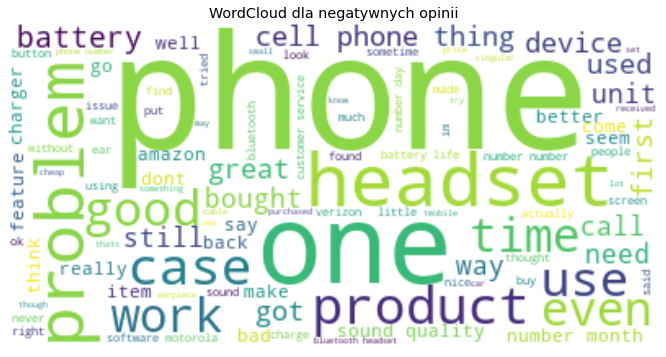

In [21]:
# Połącznie opinii
text = " ".join(review for review in df[df['score_bool'] == 0]['clean_text'])

# Wygenerowanie obrazu
wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

# Wyświetlenie
plt.figure(figsize=figure_size)
plt.title('WordCloud dla negatywnych opinii')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Na obrazie można zobaczyć, że najczęściej występują słowa takie jak "phone", "headset", "case", czy "product". Co ciekawe dużo razy użyto słowa "good" przy negatywnych opiniach. Widać tutaj też typowe słowa - "bad", "don't", "problem" czy "small".

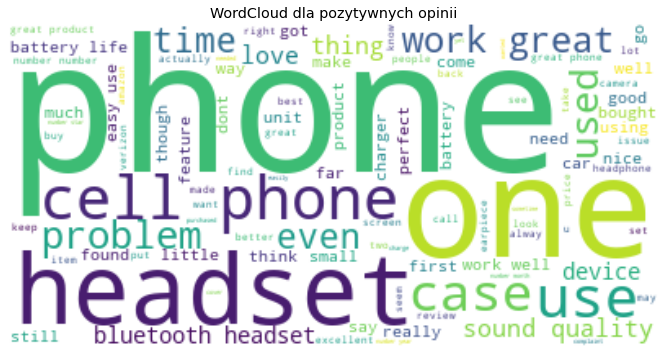

In [22]:
text = " ".join(review for review in df[df['score_bool'] == 1]['clean_text'])

wordcloud = WordCloud(max_words=100, background_color="white").generate(text)

plt.figure(figsize=figure_size)
plt.title('WordCloud dla pozytywnych opinii')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Na obrazie widać, że często występują słowa "phone", "headset", "case", czy "product", tak jak to miało miejsce również przy negatywnych opiniach. Zdecydowanie częściej występują tutaj słowa "love", "better", "well", "nice", "best". Można też zauważyć, że dosyć często występuje słowo "problem."

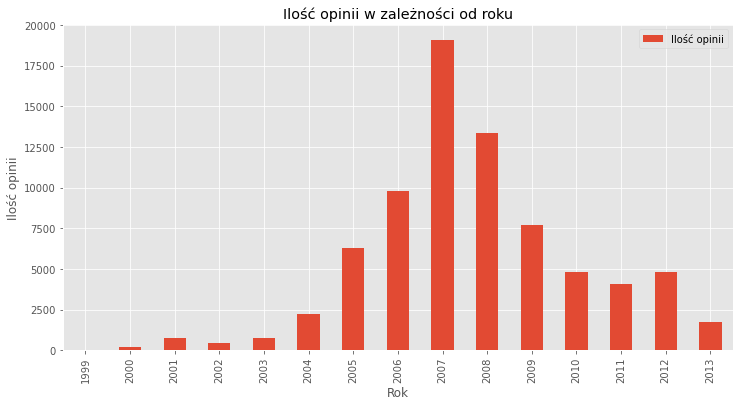

In [23]:
df['year'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od roku", 'Rok', 'Ilość opinii')

Do 2007 roku widać wykładniczy wzrost liczby opinii, co może być spowodowane zwiększeniem zapotrzebowania na telefony komórkowe oraz akcesoria. W 2008 roku widać spadek o około 6000, może to być spowodowane kryzysem gospodarczym (klienci nie kupowali telefonów komórkowych oraz akcesoriów, więc nie wystawiali opinii). Nie tłumaczy to jednak spadku ilości opinii w następnych latach. Sprzedaż komórek na rynku znacząco rosła w tych latach, a ilość opinii malała. Może to być spowodowane zmniejszeniem sie sprzedaży bezpośrednio u firmy Amazon, może być też spowodowane wzrostem niechęci do wystawiania komentarzy. Jednakże najprawdopodobniejszym wyjaśnieniem jest sposób zbierania danych. Nie udało mi się dotrzeć do informacji w jaki sposób było to przeprowadzone.

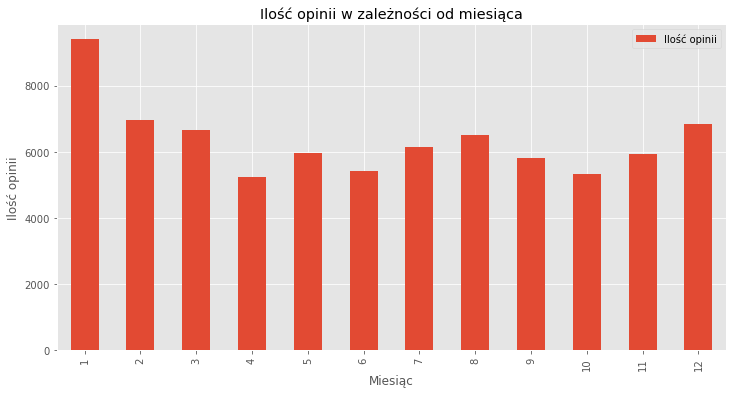

In [24]:
df['month'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od miesiąca", 'Miesiąc', 'Ilość opinii')

Najwięcej opinii było wystawianych w styczniu, lutym oraz grudniu. Może to wynikać z podwyższonej sprzedaży elektroniki w czasie black friday, świąt oraz nowego roku.

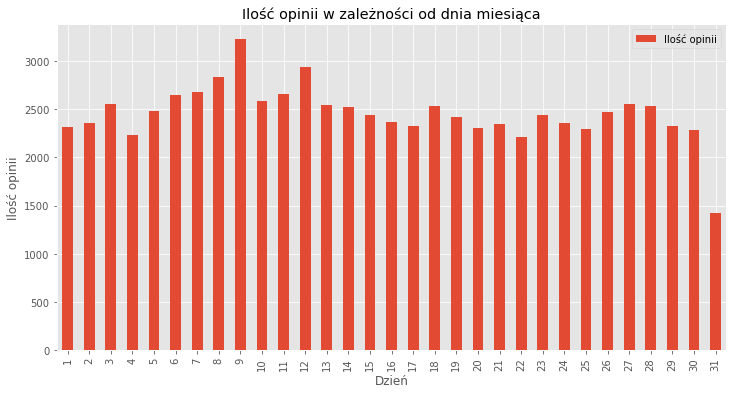

In [26]:
df['day'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od dnia miesiąca", 'Dzień', 'Ilość opinii')

Pierwsze, co można zauważyć na wykresie, to zmniejszona ilość wystawianych opinii 31 dnia miesiąca. Wynika to z mniejszej liczby dni w roku, spowodowanej podziałem miesięcy na 30 oraz 31-dniowe (wyłączając z tego luty). Reszta dni posiada podobną liczbę opinii.

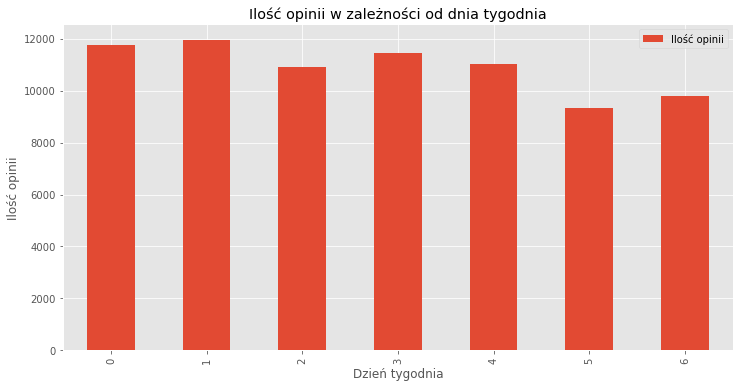

In [27]:
df['weekday'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w zależności od dnia tygodnia", 'Dzień tygodnia', 'Ilość opinii')

Od poniedziałku do piątku użytkownicy wystawiają podobną ilosć opinii. Widać, że w sobotę oraz niedzielę ta ilość jest mniejsza.

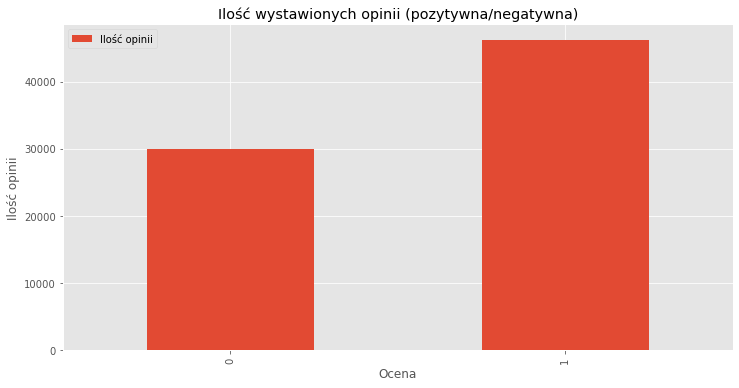

In [28]:
df['score_bool'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość wystawionych opinii (pozytywna/negatywna)", 'Ocena', 'Ilość opinii')

Ilosć opinii pozytywnych jest zdecydowanie większa od opinii negatywnych.

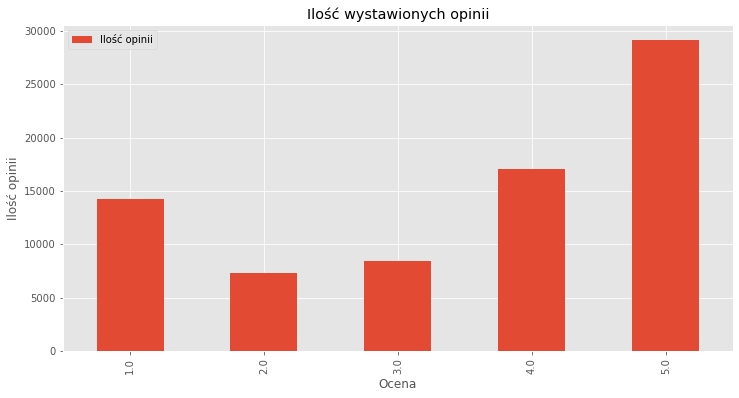

In [29]:
df['score'].value_counts().sort_index().plot(kind='bar', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość wystawionych opinii", 'Ocena', 'Ilość opinii')

Użytkownicy najczęściej wystawiają opinie z oceną 4 lub 5. Następną w kolejności pod względem występowania jest ocena 1. Klienci najrzadziej wystawiają opinię z oceną 2 oraz 3. 

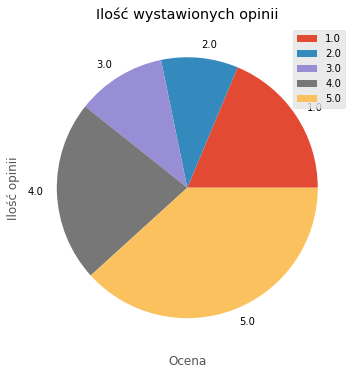

In [30]:
df['score'].value_counts().sort_index().plot(kind='pie', label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość wystawionych opinii", 'Ocena', 'Ilość opinii')

Wykres przedstawia te same dane co poprzedni, ale widać tutaj udział procentowy poszczególnych opinii.

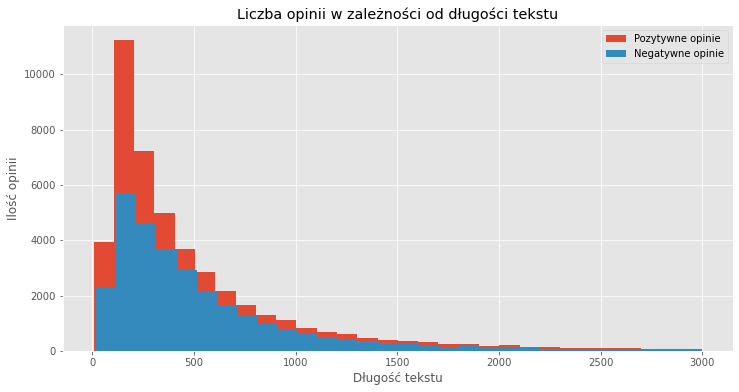

In [31]:
df.loc[df['text_length'].where(df['score_bool'] == 1) < 3000]['text_length'].plot(bins=30, kind='hist', label='Pozytywne opinie', figsize=figure_size)
df.loc[df['text_length'].where(df['score_bool'] == 0) < 3000]['text_length'].plot(bins=30, kind='hist', label='Negatywne opinie', figsize=figure_size)
set_plot_properties('Liczba opinii w zależności od długości tekstu', 'Długość tekstu', 'Ilość opinii')

Długość tekstu wyświetlana na wykresie została ogranicznona do 3000 ze względu na przejrzystość. Na wykresie widać, że pozytytwnych opinii jest zdecydowanie więcej. Rozkładają się one podobnie. Można zauważyć, że w pierwszym przedziale jest mniej opinii niż w drugim. Może to wynikać z tego, że jak użytkownik zdecyduje się na napisanie opinii, to napisze przyjnamniej 1-2 zdania, które mają łącznie rozmiar ponad 100 znaków.

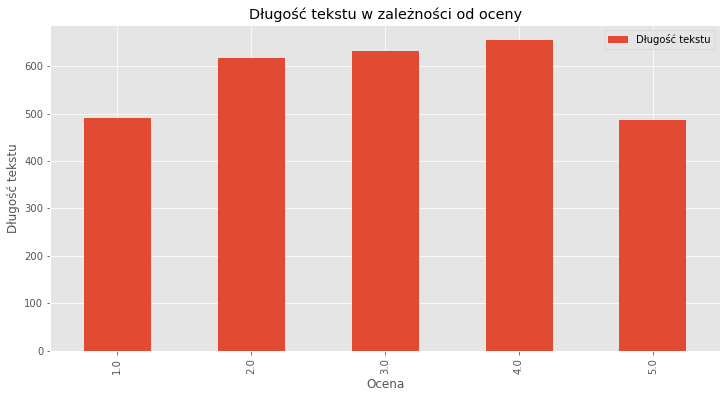

In [32]:
df.groupby('score')['text_length'].mean().plot(kind='bar', label='Długość tekstu', figsize=figure_size)
set_plot_properties("Długość tekstu w zależności od oceny", 'Ocena', 'Długość tekstu')

Użytkownicy, którzy mieli mieszane zdanie (oceny 2, 3, 4) piszą najdłuższe opinie. Klienci którzy byli całkowicie zadowoleni lub niezadowoleni, piszą krótsze opinie średnio o ponad 100 znaków.

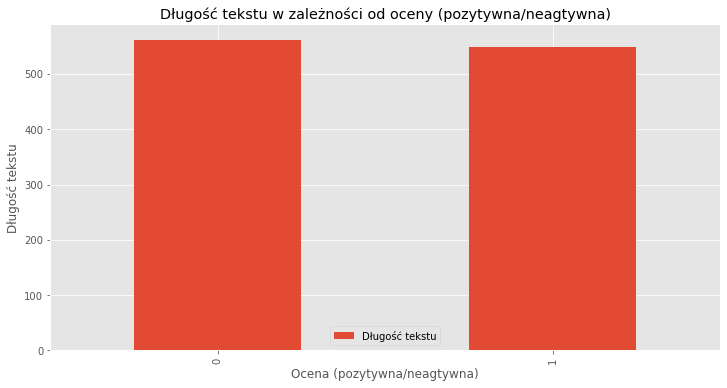

In [33]:
df.groupby('score_bool')['text_length'].mean().plot(kind='bar', label='Długość tekstu', figsize=figure_size)
set_plot_properties("Długość tekstu w zależności od oceny (pozytywna/neagtywna)", 
                    'Ocena (pozytywna/neagtywna)', 'Długość tekstu')

Nie ma znaczącej różnicy pomiędzy długością tekstu opinii pozytywnej i negatywnej.

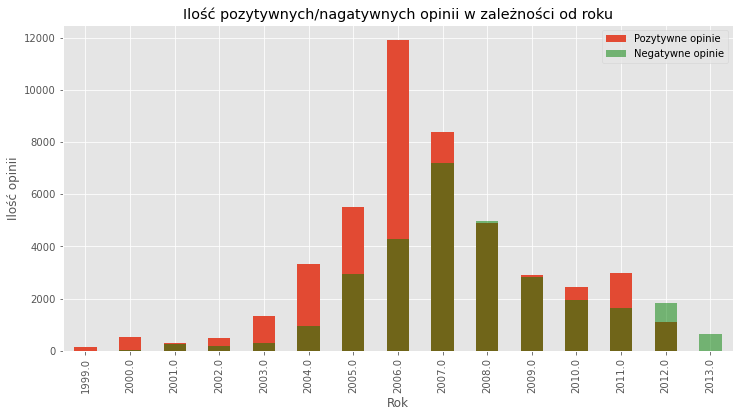

In [34]:
df['year'].where(df['score_bool'] == 1).value_counts().sort_index().plot(kind='bar', 
                                                                         label='Pozytywne opinie', figsize=figure_size)
df['year'].where(df['score_bool'] == 0).value_counts().sort_index().plot(kind='bar', label='Negatywne opinie', 
                                                                         color='g', figsize=figure_size, alpha=0.5)
set_plot_properties("Ilość pozytywnych/nagatywnych opinii w zależności od roku", 'Rok', 'Ilość opinii')

Stosunek ilości pozytywnych opinii do negatywnych bardzo się różni na przestrzeni lat. Do 2006 roku włącznie, znacznie przeważały opinie pozytywne. W latach 2007-2010 ilość opinii była zbliżona. W 2012 roku Ilość opinii pozytywnych była większa. Co ciekawe, w 2013 roku były same pozytywne opinie.

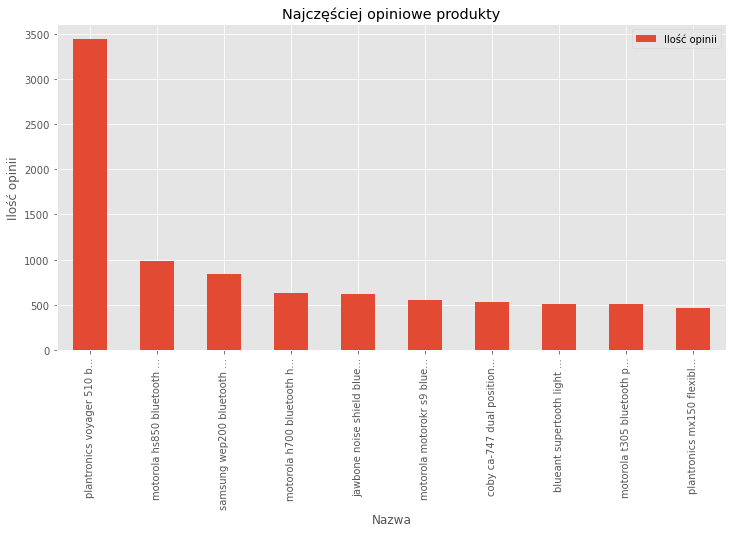

In [35]:
df['title'].value_counts()[:10].plot(kind='bar', label='Ilość opinii', figsize=figure_size)
plt.xticks([i for i in range(10)], labels=[str(xtick[:25]) + '...' for xtick in df['title'].value_counts().index[:10]])
set_plot_properties("Najczęściej opiniowe produkty", 'Nazwa', 'Ilość opinii')

Słuchawki Plantronics Voyager 510 sprzedawały się najczęściej, prawie 3,5 krotnie częściej niż drugi przedmiot. 

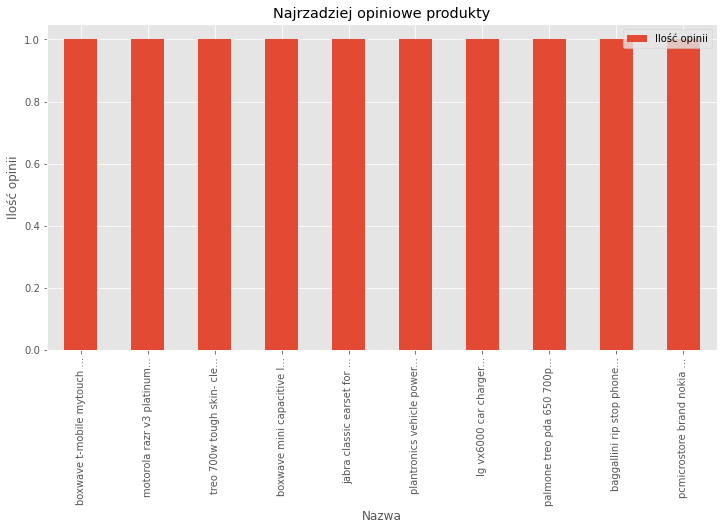

In [36]:
df['title'].value_counts()[-10:].plot(kind='bar', label='Ilość opinii', figsize=figure_size)
plt.xticks([i for i in range(10)], labels=[str(xtick[:25]) + '...' for xtick in df['title'].value_counts().index[-10:]])
set_plot_properties("Najrzadziej opiniowe produkty", 'Nazwa', 'Ilość opinii')

Na wykresie zostały przedstawione najrzadziej opiniowane produkty. Mają one tylko po jednej opinii.

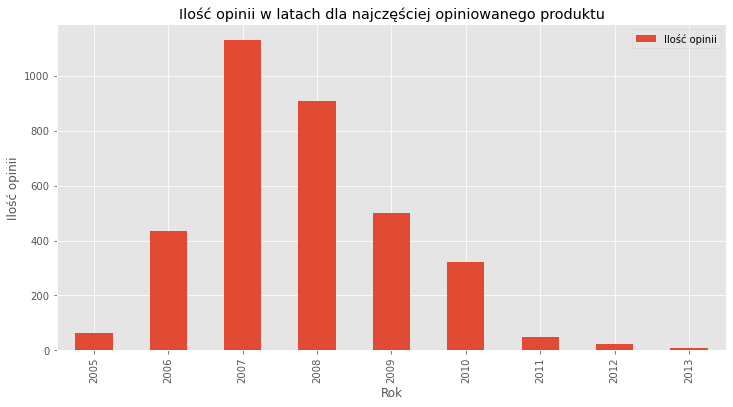

In [37]:
df[df['title'] == df['title'].value_counts().index[0]].groupby('year').count()['title'].plot(kind='bar', 
                                                                                label='Ilość opinii', figsize=figure_size)
set_plot_properties("Ilość opinii w latach dla najczęściej opiniowanego produktu", 'Rok', 'Ilość opinii')

Można zauważyć, że ilosć opinii dla najczęściej opiniowanego produktu znacząco się różniła na przestrzeni lat. Najwięcej opinii uzyskał w latach 2007 oraz 2008.
# Polecanie produktów innym użytkownikom
### Sposób 1
Określenie par przedmiotów, które są najczęściej razem komentowane przez użytkowników. Jeżeli osoba kupi przedmiot, można jej polecić przedmioty, którym użytkownicy, którzy już kupili ten przedmiot, wystawili najwięcej opinii. 

In [38]:
# Skopiowanie danych
df_bought_together = df.copy()

# 1 użytkownik mógł wystawić wiele opinii do tego samego produktu, co będzie w tej chwili generowało niepotrzebne powtórzenia
df_bought_together = df_bought_together.drop_duplicates(subset=['title', 'user_id'])

# Utworzenie  DataFrame z użytkownikami, którzy wystawili przynajmniej 2 opinie
df_bought_together = df_bought_together[df_bought_together['user_id'].duplicated(keep=False)]

# Utworzenie kolumny, w której są wszystkie produkty, którym użytkownik wystawił opinię
df_bought_together['grouped_products'] = df_bought_together.groupby('user_id')['title'].transform(lambda x: ';;;'.join(x))

# Zostawienie tylko 2 potrzebnych kolumn, oraz usunięcie duplikatów, które powstały w wyniku poprzedniej operacji
df_bought_together = df_bought_together[['user_id', 'grouped_products']].drop_duplicates()

count = Counter()

# Policzenie wystąpień par przedmiotów
for row in df_bought_together['grouped_products']:
    product_list = row.split(';;;')
    count.update(Counter(combinations(product_list, 2)))

# Wypisanie najczęściej kupowanych ze sobą par przedmiotów
for key, value in count.most_common(5):
    print(f'Przedmiot 1: {key[0]}\nPrzedmiot 2: {key[1]}\nLiczba klientów, ' +
          f'którzy wystawili opinię do obu produktów : {value}\n')

Przedmiot 1: palmone m100 series faceplate cover (blue mist)
Przedmiot 2: palmone m100 series faceplate cover (silver mist)
Liczba klientów, którzy wystawili opinię do obu produktów : 37

Przedmiot 1: tracfone prepaid airtime card, 100 units for tracfone phones
Przedmiot 2: tracfone prepaid airtime card, 40 units for tracfone phones
Liczba klientów, którzy wystawili opinię do obu produktów : 23

Przedmiot 1: motorola hs850 bluetooth headset (color sent based on availability. comes in black, blue and grey, or silver)[bulk packaged]
Przedmiot 2: plantronics voyager 510 bluetooth headset [retail packaging]
Liczba klientów, którzy wystawili opinię do obu produktów : 21

Przedmiot 1: motorola h700 bluetooth headset [motorola retail packaging]
Przedmiot 2: motorola blt-04 bluetooth headset carrying case
Liczba klientów, którzy wystawili opinię do obu produktów : 20

Przedmiot 1: naztech ultima case - small/medium flip phones - samsung, lg, motorola, and nokia - baby pink
Przedmiot 2: naztech

Na przykład, jeżeli klient kupi motorola h700 bluetooth headset [motorola retail packaging], można polecić pokrowiec motorola blt-04 bluetooth headset carrying case. Opinię do tych dwóch przedmiotów wystawiło 20 użytkowników.
Ta strategia powinna podnieść sprzedaż, ale na pewno lepszym rozwiązaniem byłoby wykorzystanie tej metody na danych sprzedażowych, nie na opiniach.
Główną wadą tego sposobu jest, to, że klient musi wystawić opinię, aby na tej podstawie mogła być wyświetlona propozycja produktu. Dlatego przechodzę do sposobu 2, gdzie nie są wymagane wcześniejsze zakupy użytkownika.
### Sposób 2
Bardzo prosta, ale skuteczna metoda - proponowanie użytkownikom produktów, które mają najwięcej pozytywnych opinii.

In [39]:
# Przedmioty, które mają pozytywną opinię
temp_df = df[df['score'] == 1]

# Policzenie 5 najczęściej pozytywnie opiniowanych produktów
temp_df = temp_df['title'].value_counts().head()

# Wyświetlenie danych
for title, value in temp_df.iteritems():
    print(f'Przedmiot: {title}\nIlość pozytywnych opinii: {value}\n')

Przedmiot: plantronics voyager 510 bluetooth headset [retail packaging]
Ilość pozytywnych opinii: 188

Przedmiot: motorola hs850 bluetooth headset (color sent based on availability. comes in black, blue and grey, or silver)[bulk packaged]
Ilość pozytywnych opinii: 167

Przedmiot: motorola motorokr s9 bluetooth active headphones (red,black) [retail packaging]
Ilość pozytywnych opinii: 135

Przedmiot: jawbone noise shield bluetooth headset (black) [retail packaged]
Ilość pozytywnych opinii: 132

Przedmiot: coby ca-747 dual position cd/md/mp3 cassette adapter
Ilość pozytywnych opinii: 121



# Klasyfikacja opinii
Przypisanie klasy opinii (pozytywnej lub negatywnej) na podstawie tekstu napisanego przez użytkownika.

In [40]:
# Funkcja zamieniająca text w wektor liczb
def count_vector(data):
    count_vectorizer = CountVectorizer(max_features=1000) # max_features=1000 - ze względu na ograniczone zasoby obliczeniowe
    vect = count_vectorizer.fit_transform(data)
    return vect.toarray(), count_vectorizer

In [41]:
# Rozbicie danych na zbiór treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], df['score_bool'], test_size = 0.3)

# Zamiana tekstu na wektor liczb
x_train, count_vectorizer = count_vector(x_train)
x_test = count_vectorizer.transform(x_test).toarray()

### Jednowarstwowa, jednokierunkowa sieć neuronowa

In [42]:
input_dim = x_train.shape[1]

# Zdefiniowanie jednowarstwowej, jednokierunkowej sieci neuronowej
model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['binary_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                32032     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 32,065
Trainable params: 32,065
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Wcześniejsze zatrzymanie treningu, jeżeli przestanie się poprawiać. Pzywrócenie najlepszych wag
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    validation_data=(x_test,y_test),
    batch_size=256,
    epochs=100,
    callbacks=[early_stopping],
    verbose=True)

Train on 53341 samples, validate on 22861 samples
Epoch 1/100
53341/53341 [==============================] - 1s 16us/sample - loss: 0.4474 - binary_accuracy: 0.8065 - val_loss: 0.3790 - val_binary_accuracy: 0.8482
Epoch 2/100
53341/53341 [==============================] - 0s 9us/sample - loss: 0.3633 - binary_accuracy: 0.8513 - val_loss: 0.3679 - val_binary_accuracy: 0.8487
Epoch 3/100
53341/53341 [==============================] - 0s 8us/sample - loss: 0.3500 - binary_accuracy: 0.8556 - val_loss: 0.3652 - val_binary_accuracy: 0.8480
Epoch 4/100
53341/53341 [==============================] - 0s 9us/sample - loss: 0.3369 - binary_accuracy: 0.8585 - val_loss: 0.3550 - val_binary_accuracy: 0.8528
Epoch 5/100
53341/53341 [==============================] - 0s 8us/sample - loss: 0.3226 - binary_accuracy: 0.8626 - val_loss: 0.3492 - val_binary_accuracy: 0.8527
Epoch 6/100
53341/53341 [==============================] - 0s 9us/sample - loss: 0.3105 - binary_accuracy: 0.8679 - val_loss: 0.3442 -

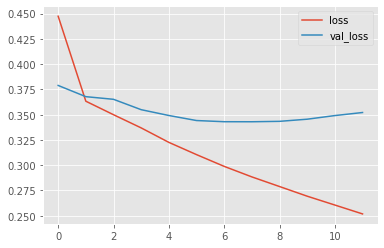

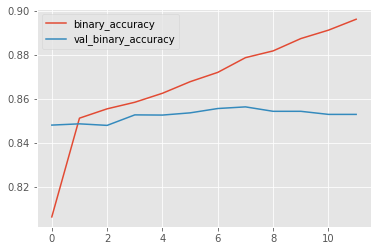

In [44]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

scores = {}
scores["Neural Network"] = round(max(history.history['val_binary_accuracy']) * 100, 2)

Funkcja do treningu modeli oraz predykcji.

In [45]:
def train_and_predict(x_train, y_train, x_test, model):

    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    return y_pred

### Drzewo decyzyjne

In [46]:
y_pred = train_and_predict(x_train, y_train, x_test, DecisionTreeClassifier())
scores['Decision Tree'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Decision Tree accuracy: {scores["Decision Tree"]} %')

Decision Tree accuracy: 73.72 %


### Las losowy

In [47]:
y_pred = train_and_predict(x_train, y_train, x_test, RandomForestClassifier())
scores['Random Forest'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Random Forest accuracy: {scores["Random Forest"]} %')

Random Forest accuracy: 83.28 %


### XGBoost

In [48]:
y_pred = train_and_predict(x_train, y_train, x_test, 
                                   XGBClassifier(n_estimators=50, eval_metric="mlogloss", use_label_encoder=False))
scores['XGBoost'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'XGBoost accuracy: {scores["XGBoost"]} %')

XGBoost accuracy: 83.12 %


### Maszyna wektorów nośnych

In [49]:
y_pred = train_and_predict(x_train[:10000], y_train[:10000], x_test, svm.SVC())
scores['SVM'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'SVM accuracy: {scores["SVM"]} %')

SVM accuracy: 83.08 %


### Naiwny klasyfikator bayesowski

In [50]:
y_pred = train_and_predict(x_train, y_train, x_test, GaussianNB())
scores['Naive Bayes'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Naive Bayes accuracy: {scores["Naive Bayes"]} %')

Naive Bayes accuracy: 78.72 %


### Regresja logistyczna

In [51]:
y_pred = train_and_predict(x_train, y_train, x_test, LogisticRegression(max_iter=500))
scores['Logistic Regression'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'Logistic Regression accuracy: {scores["Logistic Regression"]} %')

Logistic Regression accuracy: 85.01 %


### K-najbliższych sąsiadów

In [52]:
y_pred = train_and_predict(x_train, y_train, x_test, KNeighborsClassifier())
scores['K-Nearest Neighbors'] = round(accuracy_score(y_test, y_pred) * 100, 2)

print(f'K-Nearest Neighbors accuracy: {scores["K-Nearest Neighbors"]} %')

K-Nearest Neighbors accuracy: 68.75 %


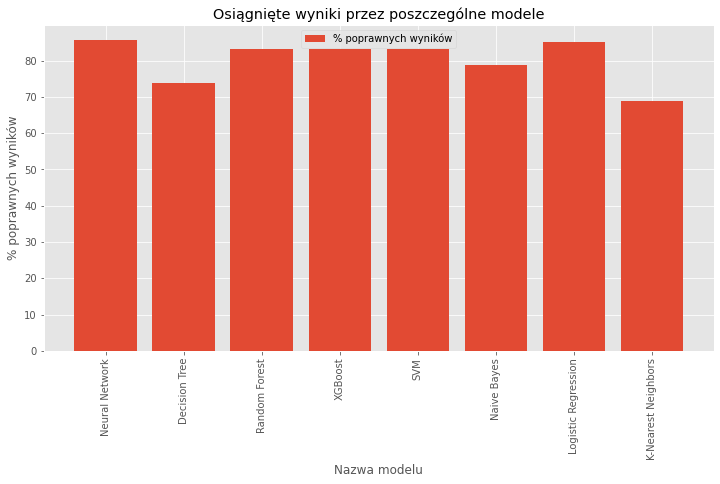

In [53]:
plt.figure(figsize=figure_size)
plt.bar(range(len(scores)), list(scores.values()), label='% poprawnych wyników')
plt.xticks(range(len(scores)), list(scores.keys()), rotation='vertical')
set_plot_properties("Osiągnięte wyniki przez poszczególne modele", 
                    'Nazwa modelu', '% poprawnych wyników')

Najlepiej z klasyfikacją komentarzy poradziła sobie jednokierunkowa, jednowarstwowa sieć neuronowa. Uzyskała ona wynik 85,64 %. Najgorzej wypadł model K-najbliższych sąsiadów z wynikiem 68,75 %. Nieznacznie lepiej poradził sobie model drzewa decyzyjnego - 73,72 %. Modele lasu losowego, XGBoost, maszyna wektorów noścny, naiwny klasyfikator bayesowski oraz regresja logistyczna uzyskały podobne wyniki od 78 do 85 %.